In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from numpy import argmax


import seaborn as sns
# from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
# from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt

from bert_score import score
from haystack.modeling.evaluation.squad_evaluation import compute_f1
from haystack.modeling.utils import initialize_device_settings
from sentence_transformers import CrossEncoder, SentenceTransformer, util
from transformers import logging
from datetime import datetime


from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

BERT_SCORE_TRAINED = 'bert_trained_score'
BERT_SCORE_VANILLA = 'bert_vanilla_score'
BI_ENCODER_SCORE = 'bi_encoder_score'
SAS_SCORE = 'sas_score'
F1_SCORE = 'f1'

BERT_MODEL_UNCASED = 'bert-base-uncased'


root_dir = '/Users/ardhendu/Documents/Home/Stanford/SAS_Project/'
input_dir = root_dir + 'data/'
output_dir = Path(root_dir + 'output3/')
col_list = ['answer1', 'answer2', 'label', 'f1', 'bert_vanilla_score','bi_encoder_score', 
            'bert_trained_score', 'sas_score']

In [6]:
DATA_PATH = 'data/table'

In [7]:
german_quad = pd.read_csv(f'{DATA_PATH}/german_quad_table_results.csv', index_col=0)
nq_open = pd.read_csv(f'{DATA_PATH}/nq_open_table_results.csv', index_col=0)
nq_open.drop_duplicates(inplace=True)
squad = pd.read_csv(f'{DATA_PATH}/squad_table_results.csv', index_col=0)

# ###################################################################
# 1. Bi-Encoder approach: 
                         T-Systems-onsite/cross-en-de-roberta-sentence-transformer
# ###################################################################

In [ ]:
squad = pd.read_csv(input_dir + 'SQuAD_SAS.csv')

model_type_trained = 'T-Systems-onsite/cross-en-de-roberta-sentence-transformer'
model = SentenceTransformer(model_type_trained)
data = squad
name = 'squad'

start = datetime.now()
#scores_bi_encoder = data.copy()
# embedding shape is torch.Size([942, 768])
embeddings1 = model.encode(data.answer1, convert_to_tensor=True)
embeddings2 = model.encode(data.answer2, convert_to_tensor=True)
## torch.Size([942, 942]).  pytorch_cos_sim calculate cosine for each string with every string
cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)
squad[F1_SCORE] = squad.apply(lambda x:compute_f1(str(x.answer1), str(x.answer2)), axis=1)

squad[BI_ENCODER_SCORE] = np.around(cosine_scores.diag().tolist(), 2)

print('time taken', datetime.now() - start)

###################################################################
# 2. BERTScore vanilla approach :-
                               En: bert-base-uncased 2nd layer
                               de: deepset/gelectra-base
###################################################################

In [ ]:
start = datetime.now()
P, R, english_bert_score = score(list(squad.answer1.values),
                                 list(squad.answer2.values),
                                 model_type=BERT_MODEL_UNCASED,
                                 num_layers=2, verbose=True)
squad[BERT_SCORE_VANILLA] = english_bert_score
print('time taken', datetime.now() - start)

###################################################################
# 3. BERTScore Trained approach:
                      Bi-encoder: T-Systems-onsite/cross-en-de-roberta-sentence-transformer
###################################################################

In [ ]:
start = datetime.now()
model_type_trained = 'T-Systems-onsite/cross-en-de-roberta-sentence-transformer'
## SQuAD
P, R, bert_score_prime = score(list(squad.answer1.values),
                               list(squad.answer2.values),
                               model_type=model_type_trained)

squad[BERT_SCORE_TRAINED] = bert_score_prime
print('time taken', datetime.now() - start)

# ###################################################################
# 4. Cross-Encoder approach
                         En:  cross-encoder/stsb-roberta-large
                         de:  deepset/gbert-large-sts
# ###################################################################

In [ ]:
start = datetime.now()
english_model_cross_encoder = CrossEncoder('cross-encoder/stsb-roberta-large')
squad[SAS_SCORE] = english_model_cross_encoder.predict(list(zip(squad.answer1, squad.answer2)),
                                                 show_progress_bar=False)
print('time taken', datetime.now() - start)

# Read CSV file

In [ ]:
#squad.to_csv(output_dir /'squad_all.csv', index=False)

In [2]:
squad = pd.read_csv(output_dir /'squad_all.csv')
squad.shape

print('### Duplicates')
squad[squad.duplicated(subset=['answer1', 'answer2'], keep=False)]

squad = squad.drop_duplicates(subset=['answer1', 'answer2'], keep='first')
squad.shape


squad = squad[['f1','answer1', 'answer2', 'label', 'bi_encoder_score', 
       'bert_vanilla_score', 'bert_trained_score', 'sas_score']].sort_values('label')
squad['bert_vanilla_score'] = np.around(squad['bert_vanilla_score'], 2)
squad['bert_trained_score'] = np.around(squad['bert_trained_score'], 2)
squad['sas_score'] = np.around(squad['sas_score'], 2)
squad['Note'] = np.nan
squad.head()

(942, 8)

### Duplicates


,answer1,answer2,label,f1,bi_encoder_score,bert_vanilla_score,bert_trained_score,sas_score
14,Complexity measures,complexity measures,2.0,1.0,0.86,1.000000,0.866622,0.967599
15,Complexity measures,complexity measures,2.0,1.0,0.86,1.000000,0.866622,0.967599
543,Rheinbrech,Upper Lake,0.0,0.0,0.29,0.229246,0.266701,0.009416
544,Rheinbrech,Upper Lake,0.0,0.0,0.29,0.229246,0.266701,0.009416
889,"Charleston, South Carolina",Charleston,1.0,0.5,0.82,0.651634,0.838648,0.830951
904,"Charleston, South Carolina",Charleston,1.0,0.5,0.82,0.651634,0.838648,0.830951


(939, 8)

,f1,answer1,answer2,label,bi_encoder_score,bert_vanilla_score,bert_trained_score,sas_score,Note
0,0.000000,Seine,Epte,0.0,0.42,0.25,0.38,0.01,NaN
467,0.000000,Arthur H. Compton,Robert A. Millikan,0.0,0.28,0.45,0.31,0.02,NaN
468,0.333333,Yuan T. Lee,Glenn T. Seaborg,0.0,0.16,0.54,0.23,0.01,NaN
469,0.000000,David Bevington,John Mearsheimer and Robert Pape,0.0,0.24,0.34,0.26,0.01,NaN
471,0.000000,Song dynasty,Mongol Empire,0.0,0.35,0.43,0.32,0.01,NaN


# Correlation when F1=0 and F1 <> 0

In [3]:
ndf = pd.DataFrame({'f1':[0 if i == 0 else 1 for i in squad.f1.tolist()],
             'label': squad.label.to_list()})

pd.crosstab(ndf.f1, ndf.label, margins=True, margins_name="Total")

print('\nPercentage crosstab\n')
np.around(pd.crosstab(ndf.f1, ndf.label, margins=True, margins_name="Total", normalize=True), 2)

label,0.0,1.0,2.0,Total
f1,,,,
0,475,65,25,565
1,57,223,94,374
Total,532,288,119,939



Percentage crosstab



label,0.0,1.0,2.0,Total
f1,,,,
0,0.51,0.07,0.03,0.6
1,0.06,0.24,0.10,0.4
Total,0.57,0.31,0.13,1.0


In [4]:
corr_method = 'kendall' #{'pearson', 'kendall', 'spearman'}
print(f'\nCorr method used {corr_method}\n')


df = squad[['label','f1', 'bi_encoder_score', 'bert_vanilla_score', 'bert_trained_score', 'sas_score' ]]

df[df.f1 == 0].corr(method=corr_method).loc[['label']]
df[df.f1 != 0].corr(method=corr_method).loc[['label', 'f1']]


Corr method used kendall



,label,f1,bi_encoder_score,bert_vanilla_score,bert_trained_score,sas_score
label,1.0,NaN,0.306837,0.109141,0.322544,0.361455


,label,f1,bi_encoder_score,bert_vanilla_score,bert_trained_score,sas_score
label,1.000000,0.494501,0.569670,0.494256,0.575884,0.616137
f1,0.494501,1.000000,0.625096,0.684760,0.640052,0.544101


In [5]:
def get_index_where_label_and_score_differ_significantly(score_name:str, label:int):
    if label == 0:
        # we expect score to be near 0. So, score should be less than 0.25
        label_0_cond_bad = ((squad['label'] == label) & (squad[score_name] >= 0.25))
        return set(squad[label_0_cond_bad].index.tolist())
    elif label == 1:
        # we expect score to be between 0.25 and 0.75. So, anything less than or greater than 0.75 is bad
        label_1_cond_bad = ((squad['label'] == label) & ((squad[score_name] <= 0.25) | (squad[score_name] >= 0.75)))
        return set(squad[label_1_cond_bad].index.tolist())
    elif label == 2:
        # we expect score to be above 0.75. So, any score less than 0.75 is bad
        label_2_cond_bad = ((squad['label'] == label) &  (squad[score_name] < 0.75))
        return set(squad[label_2_cond_bad].index.tolist())


def get_index_beyond_threshold(label_value:int):
    bi_encoder_bad_index = get_index_where_label_and_score_differ_significantly(BI_ENCODER_SCORE, label=label_value)
    bert_vanilla_bad_index = get_index_where_label_and_score_differ_significantly(BERT_SCORE_VANILLA, label=label_value)
    bert_trained_bad_index = get_index_where_label_and_score_differ_significantly(BERT_SCORE_TRAINED, label=label_value)
    sas_bad_index = get_index_where_label_and_score_differ_significantly(SAS_SCORE, label=label_value)
    
    return (bi_encoder_bad_index, bert_vanilla_bad_index, bert_trained_bad_index, sas_bad_index)

def get_index_sas_struggle(label_value):    
    bi_encoder_bad_index, bert_vanilla_bad_index, bert_trained_bad_index, sas_bad_index = \
        get_index_beyond_threshold(label_value)
    
    d = {'BERT Vanilla': len(bert_vanilla_bad_index), 
     'Bi-Encoder': len(bi_encoder_bad_index), 
     'BERT Trained': len(bert_trained_bad_index),
     'SAS': len(sas_bad_index)
    }
    bad_index_count = pd.Series(data=d, name='count_beyond_threshold')
    
    
    sas_only_not_in_vanilla = sas_bad_index - bert_vanilla_bad_index
    sas_only_not_in_bi_encoder = sas_bad_index - bi_encoder_bad_index
    sas_only_not_in_bert_trained = sas_bad_index - bert_trained_bad_index
    
    
    return bad_index_count, (sas_only_not_in_vanilla, sas_only_not_in_bi_encoder, sas_only_not_in_bert_trained)

In [6]:
# squad_df.loc[535, 'Note'] = 'translation'
# squad_df.loc[553, 'Note'] = 'translation'

# squad_df.loc[137, 'Note'] = 'medical'
# squad_df.loc[208, 'Note'] = 'biology'

# squad_df.loc[217, 'Note'] = 'translation'
# squad_df.loc[221, 'Note'] = 'train'
# squad_df.loc[255, 'Note'] = 'numbers'
# squad_df.loc[363, 'Note'] = 'train'
# squad_df.loc[119, 'Note'] = 'chemistry'
# squad_df.loc[551, 'Note'] = 'translation'
# squad_df.loc[496, 'Note'] = 'acronyms'
# squad_df.loc[542, 'Note'] = 'translation'
# squad_df.loc[52, 'Note'] = 'train'

number = 'number'
translation = 'translation'
train = 'train'
no_similarity = 'f1_0_uncanny_similarity'

# Label= 0

## Is everyone is strugging at the same pair of sentences?

Does it matter f1 is 0 or not?

In [20]:
bad_count_df, \
(sas_struggle_but_not_vanilla,
 sas_struggle_but_not_bi_encoder, 
 sas_struggle_but_not_bert_trained)= get_index_sas_struggle(0)

bad_count_df.to_frame()
np.around(1- bad_count_df.to_frame()/532, 2).rename({'count_beyond_threshold': 'percentage_accuracy'}, axis=1)

only_sas_struggle_index = \
sas_struggle_but_not_bi_encoder.intersection(sas_struggle_but_not_bert_trained)

squad.loc[only_sas_struggle_index,col_list].sort_values(['sas_score']).shape
print('\n F1=0\n')
squad.loc[squad.index.isin(only_sas_struggle_index) & (squad.f1 == 0),
          col_list].sort_values(['sas_score'])

print('\n F1> 0\n')
squad.loc[squad.index.isin(only_sas_struggle_index) & (squad.f1 != 0),
          col_list].sort_values(['sas_score'])

,count_beyond_threshold
BERT Vanilla,496
Bi-Encoder,202
BERT Trained,195
SAS,67


,percentage_accuracy
BERT Vanilla,0.07
Bi-Encoder,0.62
BERT Trained,0.63
SAS,0.87


(13, 8)


 F1=0



,answer1,answer2,label,f1,bert_vanilla_score,bi_encoder_score,bert_trained_score,sas_score
377,would do more harm than good,it focuses attention on the threat of punishment and not the moral reasons t...,0.0,0.0,0.34,0.20,0.23,0.25
446,human capital is neglected,a lower level of economic utility in society,0.0,0.0,0.35,0.24,0.24,0.26
240,connection-oriented operations. But X.25 does it at the network layer of the...,a handshake between the communicating parties before any user packets are tr...,0.0,0.0,0.38,0.21,0.24,0.26
196,explanations are reasonably well supported,by the available data,0.0,0.0,0.32,0.19,0.19,0.27
79,some of the Huguenots were nobles trying to establish separate centers of po...,political reasons,0.0,0.0,0.30,0.03,0.08,0.27
437,period of compression,decrease in wages,0.0,0.0,0.40,0.23,0.24,0.31
370,general disobedience,great amount of it,0.0,0.0,0.28,0.08,0.11,0.38
359,tempted to enter the test site,protest,0.0,0.0,0.37,0.21,0.21,0.41
182,in Article 5,the lawfulness of an action depends on whether it was appropriate and necess...,0.0,0.0,0.33,0.15,0.16,0.42



 F1> 0



,answer1,answer2,label,f1,bert_vanilla_score,bi_encoder_score,bert_trained_score,sas_score
508,50–140 cm,9–88 cm,0.0,0.500000,0.73,0.07,0.14,0.26
212,515 million years,66 million years ago,0.0,0.571429,0.73,0.15,0.22,0.41
863,most densely populated,most,0.0,0.500000,0.63,0.10,0.12,0.42
213,515 million years,66 million years,0.0,0.666667,0.83,0.16,0.23,0.42


In [8]:
f1_0_uncanny_similarity_index  = squad.loc[squad.index.isin(only_sas_struggle_index) & (squad.f1 == 0),
          col_list].sort_values(['sas_score']).index.tolist()

squad.loc[f1_0_uncanny_similarity_index, 'Note'] = no_similarity

In [9]:
squad.loc[[508,212, 213], 'Note'] = number

Text(0.5, 1.0, 'Label 0 Score')

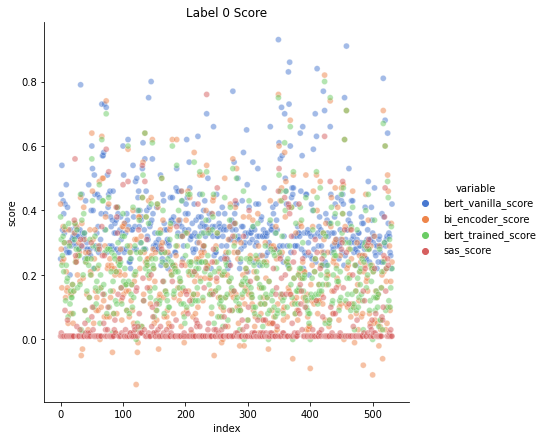

In [10]:
score_col_list = ['bert_vanilla_score', 'bi_encoder_score', 'bert_trained_score', 'sas_score']

df = squad[squad['label'] == 0][score_col_list].reset_index(drop=True).reset_index()\
.melt(id_vars=['index'],value_vars=score_col_list,value_name='score')


sns.relplot(x="index", y="score", hue="variable",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=df)
plt.title('Label 0 Score')

plt.savefig(output_dir/'label_0_score.png')

# Label= 1

## Is everyone is strugging at the same pair of sentences?

Does it matter f1 is 0 or not?

In [21]:
bad_count_df, \
(sas_struggle_but_not_vanilla,
 sas_struggle_but_not_bi_encoder, 
 sas_struggle_but_not_bert_trained)= get_index_sas_struggle(1)

bad_count_df.to_frame()
np.around(1- bad_count_df.to_frame()/288, 2).rename({'count_beyond_threshold': 'percentage_accuracy'}, axis=1)

only_sas_struggle_index = \
sas_struggle_but_not_bi_encoder.intersection(sas_struggle_but_not_bert_trained)

squad.loc[only_sas_struggle_index,col_list].sort_values(['sas_score']).shape

print('\n F1=0\n')
squad.loc[squad.index.isin(only_sas_struggle_index) & (squad.f1 == 0),
          col_list].sort_values(['sas_score'])

print('\n F1> 0\n')
squad.loc[squad.index.isin(only_sas_struggle_index) & (squad.f1 != 0),
          col_list].sort_values(['sas_score'])


,count_beyond_threshold
BERT Vanilla,84
Bi-Encoder,120
BERT Trained,126
SAS,116


,percentage_accuracy
BERT Vanilla,0.71
Bi-Encoder,0.58
BERT Trained,0.56
SAS,0.60


(35, 8)


 F1=0



,answer1,answer2,label,f1,bert_vanilla_score,bi_encoder_score,bert_trained_score,sas_score
614,taking physical control of another,a conquest over an area,1.0,0.0,0.36,0.26,0.28,0.01
557,Ice Ages,geological period,1.0,0.0,0.43,0.44,0.41,0.01
412,Institute for Policy Studies,PolitiFact,1.0,0.0,0.24,0.37,0.35,0.01
258,East Smithfield,England,1.0,0.0,0.29,0.32,0.30,0.01
25,United States,Los Angeles,1.0,0.0,0.35,0.34,0.31,0.02
728,quantum mechanics,the work of leading theoretical physicists,1.0,0.0,0.45,0.34,0.37,0.02
419,reduce costs and maximize profits,raises the productivity of each worker,1.0,0.0,0.42,0.45,0.45,0.02
345,refusals to pay taxes,civil disobedience,1.0,0.0,0.27,0.29,0.26,0.02
453,residents willing to pay higher market rate for housing,gentrification of older neighbourhoods,1.0,0.0,0.34,0.27,0.31,0.03
310,sovereign branches of government,public official,1.0,0.0,0.36,0.29,0.28,0.05



 F1> 0



,answer1,answer2,label,f1,bert_vanilla_score,bi_encoder_score,bert_trained_score,sas_score
865,2009,the 2009 southeastern Australia heat wave,1.0,0.333333,0.53,0.39,0.46,0.05
607,"""Formal imperialism""",formal,1.0,0.666667,0.67,0.34,0.39,0.11
257,Y. p. orientalis and Y. p. medievalis,Y. pestis,1.0,0.222222,0.70,0.40,0.48,0.20
375,competing harms defense,necessity defense,1.0,0.400000,0.49,0.60,0.59,0.21
873,passenger,"extensive, electrified, passenger system",1.0,0.400000,0.57,0.29,0.43,0.25
3,Isaac Komnenos,Isaac,1.0,0.666667,0.51,0.56,0.61,0.75
794,Turing machines,deterministic Turing machines,1.0,0.800000,0.67,0.71,0.71,0.77
434,optional education,education,1.0,0.666667,0.73,0.55,0.58,0.78
801,suspected to be unequal,unequal,1.0,0.400000,0.75,0.64,0.66,0.80
854,essentials,"only ""essentials""",1.0,0.666667,0.72,0.58,0.61,0.84


In [12]:
squad.loc[[614], 'Note'] = 'history'
squad.loc[[557, 258, 25], 'Note'] = 'geography'
squad.loc[[412, 310, 318, 63], 'Note'] = 'politics'
squad.loc[[728], 'Note'] = 'physics'
squad.loc[[419,345, 453, 640, 501, 547], 'Note'] = 'finance'
squad.loc[22, 'Note'] = 'computer_science'
squad.loc[110, 'Note'] = 'chemistry'
squad.loc[214, 'Note'] = 'biology'
squad.loc[20, 'Note'] = 'math'
squad.loc[741, 'Note'] = 'physics'

squad.loc[54, 'Note'] =  'finding_too_much_similarity'

squad.loc[[865,607 ], 'Note'] = 'finding_too_less_similarity'
squad.loc[257, 'Note'] = 'biology'




Text(0.5, 1.0, 'Label 1 Score')

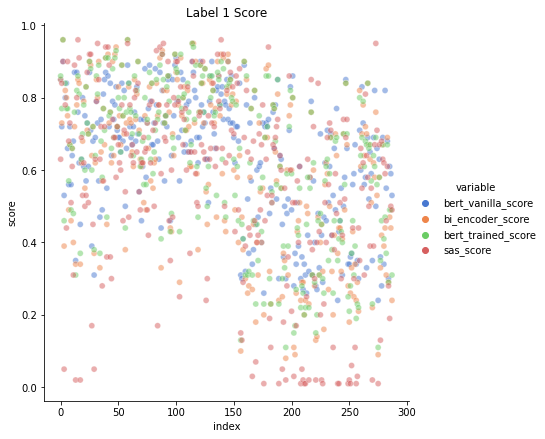

In [24]:
score_col_list = ['bert_vanilla_score', 'bi_encoder_score', 'bert_trained_score', 'sas_score']

df = squad[squad['label'] == 1][score_col_list].reset_index(drop=True).reset_index()\
.melt(id_vars=['index'],value_vars=score_col_list,value_name='score')


sns.relplot(x="index", y="score", hue="variable",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=df)

plt.title('Label 1 Score')
plt.savefig(output_dir/'label_1_score.png')

# Label= 2

## Is everyone is strugging at the same pair of sentences?

Does it matter f1 is 0 or not?

In [22]:
bad_count_df, \
(sas_struggle_but_not_vanilla,
 sas_struggle_but_not_bi_encoder, 
 sas_struggle_but_not_bert_trained)= get_index_sas_struggle(2)

bad_count_df.to_frame()
np.around(1- bad_count_df.to_frame()/119, 2).rename({'count_beyond_threshold': 'percentage_accuracy'}, axis=1)

only_sas_struggle_index = \
sas_struggle_but_not_bi_encoder.intersection(sas_struggle_but_not_bert_trained)

squad.loc[only_sas_struggle_index,col_list].sort_values(['sas_score']).shape

print('\n F1=0\n')
squad.loc[squad.index.isin(only_sas_struggle_index) & (squad.f1 == 0),
          col_list].sort_values(['sas_score'])

print('\n F1> 0\n')
squad.loc[squad.index.isin(only_sas_struggle_index) & (squad.f1 != 0),
          col_list].sort_values(['sas_score'])



,count_beyond_threshold
BERT Vanilla,36
Bi-Encoder,28
BERT Trained,27
SAS,31


,percentage_accuracy
BERT Vanilla,0.70
Bi-Encoder,0.76
BERT Trained,0.77
SAS,0.74


(8, 8)


 F1=0



,answer1,answer2,label,f1,bert_vanilla_score,bi_encoder_score,bert_trained_score,sas_score
553,Old Rhine,Oude Rijn,2.0,0.0,0.23,0.91,0.90,0.18
8,instances,the instance,2.0,0.0,0.66,0.79,0.78,0.71



 F1> 0



,answer1,answer2,label,f1,bert_vanilla_score,bi_encoder_score,bert_trained_score,sas_score
805,NP-complete problems,NP-complete,2.0,0.666667,0.87,0.82,0.84,0.63
927,Abercynon,Abercynon in south Wales,2.0,0.400000,0.80,0.78,0.79,0.71
755,1066,In 1066,2.0,0.666667,0.86,0.92,0.92,0.71
859,Buckland Valley,Buckland Valley near Bright,2.0,0.666667,0.83,0.79,0.82,0.72
184,the Charter of Fundamental Rights of the European Union,the Charter of Fundamental Rights of the European Union of 7,2.0,0.875000,0.95,0.85,0.88,0.73
756,King Malcolm III of Scotland,King Malcolm III,2.0,0.750000,0.85,0.85,0.85,0.73


In [15]:
squad.loc[553, 'Note'] = translation
squad.loc[8, 'Note'] = train


squad.loc[755, 'Note'] =  number
squad.loc[805, 'Note'] =  'math'
squad.loc[[927, 859], 'Note'] =  'geography'
squad.loc[[184, 756], 'Note'] =  'history'

In [16]:
## where SAS works
#squad[(squad['sas_score'] > 0.75) & (squad['label'] == 2)].sort_values('sas_score').head(30)

Text(0.5, 1.0, 'Label 2 Score')

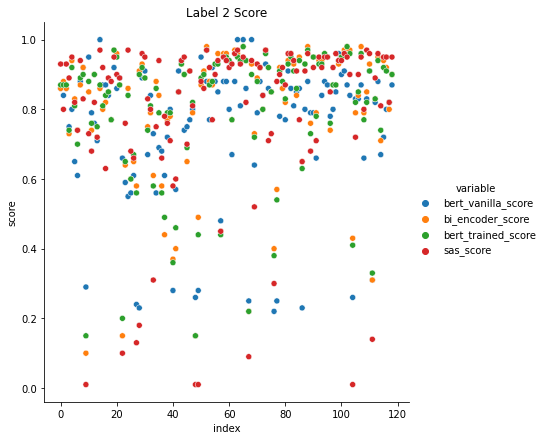

In [25]:
score_col_list = ['bert_vanilla_score', 'bi_encoder_score', 'bert_trained_score', 'sas_score']

df = squad[squad['label'] == 2][score_col_list].reset_index(drop=True).reset_index()\
.melt(id_vars=['index'],value_vars=score_col_list,value_name='score')


sns.relplot(x="index", y="score", hue="variable",
            sizes=(40, 400), 
            height=6, data=df)

plt.title('Label 2 Score')
plt.savefig(output_dir/'label_2_score.png')

## Note categorization

In [18]:
squad['Note'].value_counts()

f1_0_uncanny_similarity        9
finance                        6
geography                      5
number                         4
politics                       4
history                        3
finding_too_less_similarity    2
physics                        2
math                           2
biology                        2
computer_science               1
finding_too_much_similarity    1
chemistry                      1
translation                    1
train                          1
Name: Note, dtype: int64

# End

#### Common answer-pairs everyone struggle

In [ ]:
# # are there common answer pairs where everyone struggle?
# bad_list = {'bi_encoder': bi_encoder_bad_index, 
#            'bert_vanilla': bert_vanilla_bad_index,
#            'bert_trained': bert_trained_bad_index,
#            'sas': sas_bad_index}
# for i,j in bad_list.items():
#     if i != 'sas':
#         print(f"{i} intersection {sorted(bad_list[i].intersection(bad_list['sas']))}")

### Ony SAS struggles

In [ ]:
# sas_bad_index - bert_vanilla_bad_index
# sas_bad_index - bi_encoder_bad_index
# sas_bad_index - bert_trained_bad_index
